# Demo Subcyle example
This notebook demonstartes the capabilities comparable to current cycle sheets without weather. It uses MultiStores to represent containers for MPs and TPs. 

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

import uuid

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Site

In [2]:
# The generic site class
Site = type(
    "Site",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.Locatable,  # Add coordinates to extract distance information and visualize
        core.HasMultiContainer,  # Add information on the material available at the site
        core.HasResource,
    ),  # Add information on serving equipment
    {},
)  # The dictionary is empty because the site type is generic

# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Winlocatie",  # The name of the site
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_from_site,  # The coordinates of the project site
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 5, "capacity": 10},
        {"id": "TP", "level": 5, "capacity": 10},
    ],
}  # The actual volume of the site

# Information on the dumping site - the "to site" - the "dump locatie"
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)  # lon, lat

data_to_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Dumplocatie",  # The name of the site
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_to_site,  # The coordinates of the project site
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 0, "capacity": 5},
        {"id": "TP", "level": 0, "capacity": 5},
    ],
}  # The actual volume of the site (empty of course)

# The two objects used for the simulation
from_site = Site(**data_from_site)
to_site = Site(**data_to_site)

## Definition of Vessels

In [3]:
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.MultiContainerDependentMovable,  # A moving container, so capacity and location
        core.Processor,  # Allow for loading and unloading
        core.HasResource,  # Add information on serving equipment
        
        core.LoadingFunction,  # Add a loading function
        core.UnloadingFunction,  # Add an unloading function
        # SiteRegistry,
    ),
    {"key": "MultiStoreHopper"},
)

# print(SiteRegistry.inspect("MultiStoreHopper"))
# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: 10

# TSHD variables
data_hopper = {
    "env": my_env,  # The simpy environment
    "name": "Hopper 01",  # Name
    "ID": str(uuid.uuid4()),  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 1,  # Loading rate
    "unloading_rate": 1,  # Unloading rate
    "store_capacity": 4,
    "initials": [
        {"id": "MP", "level": 0, "capacity": 2},
        {"id": "TP", "level": 0, "capacity": 2},
    ],  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}

hopper = TransportProcessingResource(**data_hopper)

## Definition of process
The process is introduced in three parts:
- Loading process
- Unloading process
- High level process

### Definition of Loading process
The loging process consists of simulation of a cyclesheet. There are some preparatory actions, followed by a loop to load MPs, then some changes on the crane configuration before the TPs are loaded in a loop again. 

In [4]:
# definition of loading
loading = []

basic_activity_data1= {"env"  : my_env,
                      "name" : "MP loading hook on rigging",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),
                      "duration" : 45,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
loading.append(model.BasicActivity(**basic_activity_data1))

shift_amount_loading_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer MP",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "processor": hopper,
    "origin": from_site,
    "destination": hopper,
    "amount": 1,
    "duration": 120,
    "id_": "MP",
    "postpone_start": True,
}
activity_mp_loading = model.ShiftAmountActivity(**shift_amount_loading_data)
activity_mp_loading_seq_data = {
    "env": my_env,
    "name": "loading MP seq",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": [activity_mp_loading],
    "postpone_start": True,
}
activity_mp_loading_seq = model.SequentialActivity(**activity_mp_loading_seq_data)
while_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "loading MP while",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_process": activity_mp_loading_seq,
    "condition_event": [{"or":[{"type":"container", "concept": hopper, "state":"full", "id_":"MP"},
                                {"type":"container", "concept": from_site, "state":"empty", "id_":"MP"}]
                        }],
    "postpone_start": True,
}
loading.append(model.WhileActivity(**while_data))

basic_activity_data2= {"env"  : my_env,
                      "name" : "MP loading hook off rigging",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 15,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
loading.append(model.BasicActivity(**basic_activity_data2))

basic_activity_data3= {"env"  : my_env,
                      "name" : "TP loading hook on rigging",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 30,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
loading.append(model.BasicActivity(**basic_activity_data3))

shift_amount_loading_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer TP",  # We are moving soil
    "registry": registry,
    "processor": hopper,
    "origin": from_site,
    "destination": hopper,
    "amount": 1,
    "duration": 10,
    "id_": "TP",
    "postpone_start": True,
}
activity_tp_loading = model.ShiftAmountActivity(**shift_amount_loading_data2)
activity_tp_loading_seq_data = {
    "env": my_env,
    "name": "loading MP seq",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": [activity_tp_loading],
    "postpone_start": True,
}
activity_tp_loading_seq = model.SequentialActivity(**activity_tp_loading_seq_data)
while_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "loading MP while",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_process": activity_tp_loading_seq,
    "condition_event": [{"or":[{"type":"container", "concept": hopper, "state":"full", "id_":"TP"},
                                {"type":"container", "concept": from_site, "state":"empty", "id_":"TP"}]
                          }],
    #"condition_event": [{"type":"container", "concept": hopper, "state":"full", "id_":"TP"}],
    "postpone_start": True,
}
loading.append(model.WhileActivity(**while_data2))

basic_activity_data4= {"env"  : my_env,
                      "name" : "TP loading hook off rigging",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 15,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
loading.append(model.BasicActivity(**basic_activity_data4))

sequential_activity_data1 = {
    "env": my_env,
    "name": "loading",
    "ID": str(uuid.uuid4()),  # For logging purposes"registry": registry,
    "registry": registry,
    "sub_processes": loading,
    "postpone_start": True,
}

loading_activity = model.SequentialActivity(**sequential_activity_data1)


### Definition of Unloading
The unloading consists of unloading an MP and a TP with some auxilary actions.

In [5]:
# definition of unloading
#
unloading = []
move_activity_transit_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing transit",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "mover": hopper,
    "destination": to_site,
    "postpone_start": True,
}
unloading.append(model.MoveActivity(**move_activity_transit_data))
basic_activity_data20= {"env"  : my_env,
                      "name" : "MP preparing for installation",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 45,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
unloading.append(model.BasicActivity(**basic_activity_data20))
shift_amount_unloading_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Install MP",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "processor": hopper,
    "origin": hopper,
    "destination": to_site,
    "amount": 1,
    "duration": 120,
    "id_": "MP",
    "postpone_start": True,
}
unloading.append(model.ShiftAmountActivity(**shift_amount_unloading_data))
basic_activity_data21= {"env"  : my_env,
                      "name" : "Installing MP",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 45,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
unloading.append(model.BasicActivity(**basic_activity_data21))
basic_activity_data22= {"env"  : my_env,
                      "name" : "Prepare TP installation",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 45,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
unloading.append(model.BasicActivity(**basic_activity_data22))

shift_amount_unloading_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Install TP",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "processor": hopper,
    "origin": hopper,
    "destination": to_site,
    "amount": 1,
    "duration": 120,
    "id_": "TP",
    "postpone_start": True,
}
unloading.append(model.ShiftAmountActivity(**shift_amount_unloading_data2))

basic_activity_data23= {"env"  : my_env,
                      "name" : "TP finalize installation",
                      "registry": registry,
                      "ID":str(uuid.uuid4()),  # For logging purposes
                      "duration" : 45,
                      "additional_logs": [hopper],
                      "postpone_start": True,
                      }
unloading.append(model.BasicActivity(**basic_activity_data23))

sequential_activity_data2 = {
    "env": my_env,
    "name": "unloading",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": unloading,
    "postpone_start": True,
}
sequential_activity = model.SequentialActivity(**sequential_activity_data2)

while_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "unloading while",  # We are moving soil
    "ID":str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_process": sequential_activity,
    "condition_event": [{"or":[{"type":"container", "concept": to_site, "state":"full", "id_":"TP"},
                                {"type":"container", "concept": hopper, "state":"empty", "id_":"TP"}]
                          }],
    #"condition_event": [{"type":"container", "concept": hopper, "state":"empty", "id_":"TP"}],
    "postpone_start": True,
}
unloading_activity = model.WhileActivity(**while_data)

### Definition of High level Process
The high level process is based on the following steps:
- While the destination is not full do:
    - Sail empty
    - Loading
    - Sail full
    - Unloading

In [6]:
# definition of main cycle

single_run = []

move_activity_to_harbor_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing empty",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "mover": hopper,
    "destination": from_site,
    "postpone_start": True,
}
single_run.append(model.MoveActivity(**move_activity_to_harbor_data))

single_run.append(loading_activity)

move_activity_to_site_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "sailing filled",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "mover": hopper,
    "destination": to_site,
    "postpone_start": True,
}
single_run.append(model.MoveActivity(**move_activity_to_site_data))

single_run.append(unloading_activity)

sequential_activity_data3 = {
    "env": my_env,
    "name": "Single run process",
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_processes": single_run,
    "postpone_start": True,
}
activity = model.SequentialActivity(**sequential_activity_data3)

while_data = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "single run while",  # We are moving soil
    "ID": str(uuid.uuid4()),  # For logging purposes
    "registry": registry,
    "sub_process": activity,
    "condition_event": [{"type":"container", "concept": to_site, "state":"full", "id_":"TP"}],
    "postpone_start": False,
}
while_activity = model.WhileActivity(**while_data)


In [7]:
my_env.run()


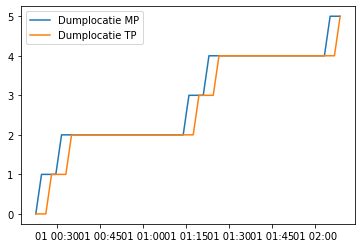

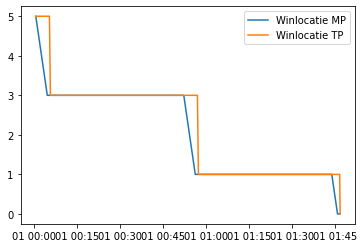

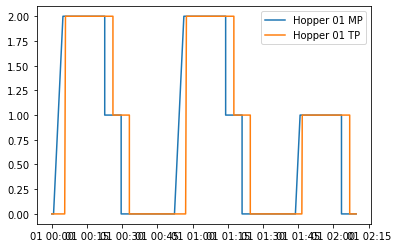

In [8]:
plot.vessel_planning([hopper, from_site, to_site])
fig = plot.get_step_chart([to_site])
fig = plot.get_step_chart([from_site])
fig = plot.get_step_chart([hopper])

In [14]:
plot.vessel_planning([*single_run, *loading, *unloading])